In [133]:
import os
import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import root_mean_squared_error as rmse

## Loading data

In [134]:
DATA_PATH = '/Users/nicolaigarderhansen/Desktop/Bachelorprojekt/Forecasting-water-inflow/Data loading and handling/Cleaned data etc./data_cleaned_and_interpolated.csv'

# Adjust these column names as needed.
date_col = 'time'
target_col = 'KarupBro'
# List of meteorological features from DMI – update if needed.
input_cols = [
    'temp_min_daily', 'temp_max_daily', 'temp_mean_daily', 
    'temp_grass_mean_daily', 'temp_soil_min_daily', 'temp_soil_max_daily', 
    'temp_soil_mean_daily', 'humidity_daily', 'wind_direction_daily', 
    'wind_speed_daily', 'wind_gust_max_daily', 'precip_total_daily', 
    'precip_duration_daily', 'radiation_global_daily', 
    'sunshine_duration_daily'
]


# Read the CSV
df = pd.read_csv(DATA_PATH, parse_dates=[date_col])
df.sort_values(date_col, inplace=True)
df.reset_index(drop=True, inplace=True)

# Optional: Set the date column as index (if needed)
df.set_index(date_col, inplace=True)

df.tail()

,temp_min_daily,temp_max_daily,temp_mean_daily,temp_grass_mean_daily,temp_soil_min_daily,temp_soil_max_daily,temp_soil_mean_daily,humidity_daily,wind_direction_daily,wind_gust_max_daily,wind_speed_daily,precip_total_daily,precip_duration_daily,radiation_global_daily,sunshine_duration_daily,KarupBro
time,,,,,,,,,,,,,,,,
2023-12-20,0.8,4.4,3.141667,2.316667,5.1,5.4,5.241667,88.583333,252.000000,12.2,2.541667,0.4,4.0,349.0,111.0,4448.18
2023-12-21,1.4,8.7,5.316667,4.637500,5.0,5.3,5.141667,86.083333,254.666667,22.5,5.329167,19.9,159.0,270.0,29.5,5602.14
2023-12-22,0.1,4.0,2.395833,1.129167,4.0,5.1,4.533333,66.000000,293.416667,19.1,5.020833,0.6,3.0,749.0,294.5,6636.60
2023-12-23,-1.6,3.3,0.833333,-0.250000,3.6,4.1,3.754167,88.000000,264.000000,10.5,2.379167,0.8,4.0,589.0,247.0,5809.15
2023-12-24,-0.3,2.1,1.120000,0.700000,3.4,3.6,3.520000,97.700000,136.500000,6.6,1.500000,5.0,38.0,9.0,0.0,5197.78


In [135]:
# Check for missing values
df.isnull().sum()

temp_min_daily             0
temp_max_daily             0
temp_mean_daily            0
temp_grass_mean_daily      0
temp_soil_min_daily        0
temp_soil_max_daily        0
temp_soil_mean_daily       0
humidity_daily             0
wind_direction_daily       0
wind_gust_max_daily        0
wind_speed_daily           0
precip_total_daily         0
precip_duration_daily      0
radiation_global_daily     0
sunshine_duration_daily    0
KarupBro                   0
dtype: int64

<Figure size 1200x1200 with 0 Axes>

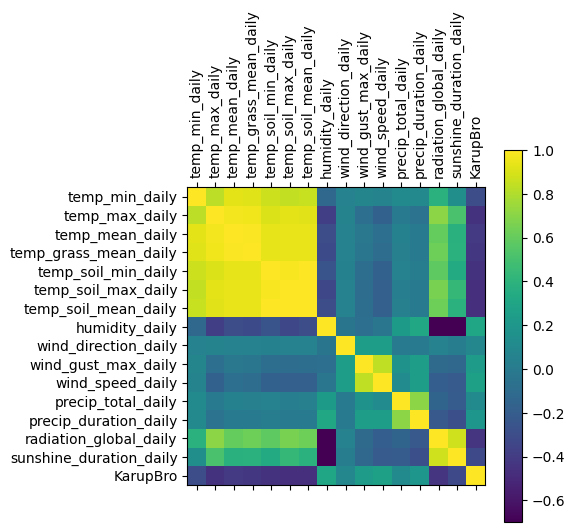

In [136]:
# Correlation matrix
corr = df.corr()
plt.figure(figsize=(12, 12))
plt.matshow(corr, fignum=2)
plt.xticks(range(len(corr.columns)), corr.columns, rotation='vertical')
plt.yticks(range(len(corr.columns)), corr.columns)
plt.colorbar()
plt.show()

## Filtering data to simple model

<Axes: xlabel='time'>

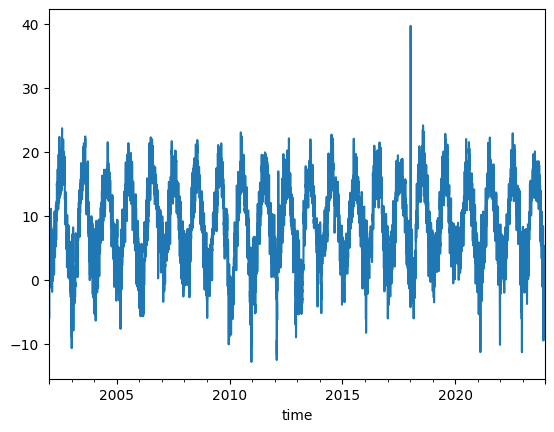

In [137]:
temp = df['temp_mean_daily']
temp.plot()

In [138]:
# Replace outliers with NaN
df.loc[df["temp_mean_daily"] > 35, "temp_mean_daily"] = np.nan

# Forward-fill (ffill) the missing values
df["temp_mean_daily"] = df["temp_mean_daily"].ffill()

<Axes: xlabel='time'>

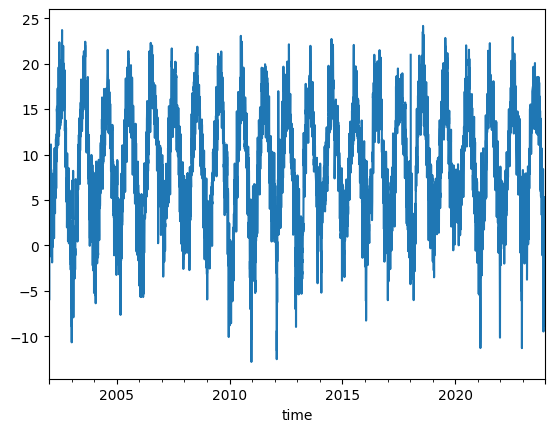

In [139]:
temp.plot()

<Axes: xlabel='time'>

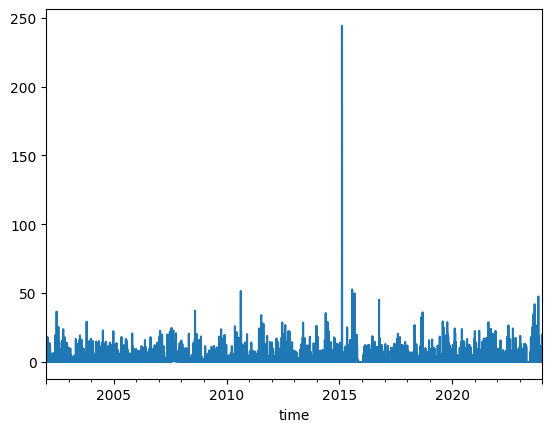

In [140]:
rain = df['precip_total_daily']
rain.plot()

In [141]:
import numpy as np

# Replace outliers with NaN
df.loc[df["precip_total_daily"] > 100, "precip_total_daily"] = np.nan

# Forward-fill (ffill) the missing values
df["precip_total_daily"] = df["precip_total_daily"].ffill()

<Axes: xlabel='time'>

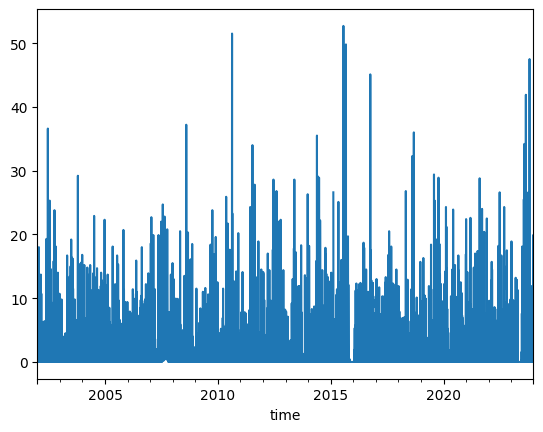

In [142]:
rain.plot()

<Axes: xlabel='time'>

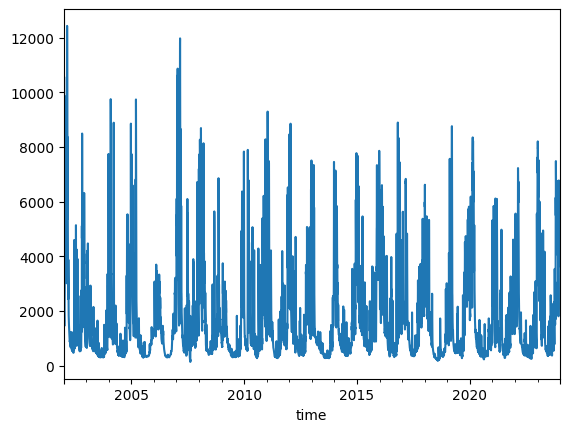

In [143]:
inflow = df['KarupBro']
inflow.plot()

## Multi-variable

In [144]:
# Create the inflow_df with the 'Inflow' column
inflow_df = pd.DataFrame({'Inflow': inflow})

# Join all columns from df into inflow_df using the index
inflow_df = inflow_df.join(df, how='left')

# Calculate a temporary 'Seconds' column based on the timestamp of the index
inflow_df['Seconds'] = inflow_df.index.map(pd.Timestamp.timestamp)

# Define constants for day and year in seconds
day = 24 * 60 * 60
year = 365.2425 * day

# Create seasonal features based on the 'Seconds' column
inflow_df['Year sin'] = np.sin(inflow_df['Seconds'] * (2 * np.pi / year))
inflow_df['Year cos'] = np.cos(inflow_df['Seconds'] * (2 * np.pi / year))

# Remove the temporary 'Seconds' column
inflow_df = inflow_df.drop(['Seconds', 'KarupBro'], axis=1)

# Display the final DataFrame
inflow_df.shape

(8028, 18)

In [145]:
import numpy as np

HORIZON = 5
WINDOW = 5

def df_to_X_y_multi_step_exo(df, window_size=WINDOW, horizon=HORIZON):
    """
    Prepares data for direct multi-step forecasting (k-step ahead) by:
      - Using the past 'window_size' days of data as historical input.
      - Including the exogenous features for the *next* 'horizon' days.
      - Predicting 'horizon' days of inflow in one shot.
    
    Assumes:
      - df columns = [Inflow, exo_1, exo_2, ..., exo_17] (total 18 columns)
      - 'window_size' = number of past days (e.g., 5)
      - 'horizon' = forecast length (e.g., 1)
    
    Returns:
      X : shape (num_samples, window_size, total_features + exo_count * horizon)
          where total_features = 18 and exo_count = 17.
          The last row of each sample contains the exogenous data for each future day.
      y : shape (num_samples, horizon)
          The inflow values for the next 'horizon' days.
    """
    df_as_np = df.to_numpy()  # shape (total_days, 18)
    total_features = df_as_np.shape[1]  # should be 18
    exo_count = total_features - 1  # 17 exogenous features (all columns except 'Inflow')

    X, y = [], []
    n = len(df_as_np)
    
    # We need enough data for 'window_size' historical days + 'horizon' future days
    for i in range(n - window_size - horizon + 1):
        # 1) Extract the historical window (all features for the past 'window_size' days)
        hist_window = df_as_np[i : i + window_size, :total_features]
        
        # 2) Extract the exogenous features for the next 'horizon' days (columns 1..total_features)
        exo_future = df_as_np[i + window_size : i + window_size + horizon, 1:total_features]
        
        # 3) Build an expanded window with shape (window_size, total_features + exo_count * horizon)
        sample = np.zeros((window_size, total_features + exo_count * horizon))
        
        # Fill columns 0..(total_features-1) with the historical data for each of the 'window_size' rows
        sample[:, :total_features] = hist_window
        
        # For the last row only, append the exogenous data for the next 'horizon' days.
        # Each day's exo data (of length exo_count) is placed sequentially.
        for day_idx in range(horizon):
            start_col = total_features + exo_count * day_idx
            end_col = start_col + exo_count
            sample[-1, start_col:end_col] = exo_future[day_idx]
        
        # 4) The label is the inflow for the next 'horizon' days (column 0)
        future_inflow = df_as_np[i + window_size : i + window_size + horizon, 0]
        
        X.append(sample)
        y.append(future_inflow)
    
    return np.array(X), np.array(y)

In [146]:
# X2, y2 = df_to_X_y2(inflow_df)
X, y = df_to_X_y_multi_step_exo(inflow_df)

X.shape, y.shape

((8019, 5, 103), (8019, 5))

In [147]:
X2_train, y2_train = X[:6000], y[:6000]
X2_val, y2_val = X[6000:7000], y[6000:7000]
X2_test, y2_test = X[7000:], y[7000:]
X2_train.shape, y2_train.shape, X2_val.shape, y2_val.shape, X2_test.shape, y2_test.shape

((6000, 5, 103),
 (6000, 5),
 (1000, 5, 103),
 (1000, 5),
 (1019, 5, 103),
 (1019, 5))

In [148]:
y_train_mean = y2_train.mean(axis=0)  # shape (horizon,)
y_train_std  = y2_train.std(axis=0)   # shape (horizon,)

# Avoid division by zero
y_train_std[y_train_std == 0] = 1e-7

### Preprocessing

In [149]:
import numpy as np

def standardize_X(X_train, X_val, X_test):
    """
    Standardizes all features in the 3D arrays (samples, window_size, num_features).
    Computes mean/std from X_train only, then applies to X_val, X_test.
    Returns: (X_train_scaled, X_val_scaled, X_test_scaled)
    """
    # Flatten the first two dimensions of X_train to compute per-feature stats
    samples_train, window_size, num_features = X_train.shape
    X_train_2d = X_train.reshape(-1, num_features)  # shape (samples_train * window_size, num_features)
    
    # Compute mean and std for each feature
    feature_means = X_train_2d.mean(axis=0)
    feature_stds = X_train_2d.std(axis=0)
    
    # Avoid division by zero if any std is zero
    feature_stds[feature_stds == 0] = 1e-7
    
    # Scale X_train
    X_train_scaled = (X_train - feature_means) / feature_stds
    
    # Scale X_val
    X_val_scaled = (X_val - feature_means) / feature_stds
    
    # Scale X_test
    X_test_scaled = (X_test - feature_means) / feature_stds
    
    return X_train_scaled, X_val_scaled, X_test_scaled

def standardize_y(y_train, y_val, y_test):
    """
    Standardizes the target arrays (samples, horizon).
    Computes mean/std from y_train only, then applies to y_val, y_test.
    Returns: (y_train_scaled, y_val_scaled, y_test_scaled)
    """
    # shape (samples_train, horizon)
    y_train_mean = y_train.mean(axis=0)
    y_train_std = y_train.std(axis=0)
    
    # Avoid division by zero if std is zero
    y_train_std[y_train_std == 0] = 1e-7
    
    # Scale y_train
    y_train_scaled = (y_train - y_train_mean) / y_train_std
    
    # Scale y_val
    y_val_scaled = (y_val - y_train_mean) / y_train_std
    
    # Scale y_test
    y_test_scaled = (y_test - y_train_mean) / y_train_std
    
    return y_train_scaled, y_val_scaled, y_test_scaled

# Standardize all X
X2_train, X2_val, X2_test = standardize_X(X2_train, X2_val, X2_test)

# Standardize all y
y2_train, y2_val, y2_test = standardize_y(y2_train, y2_val, y2_test)


In [150]:
X2_test[0] , y2_test[0]

(array([[-1.61786932e-01, -1.51307829e+00, -3.06175583e-01,
         -1.02918874e+00, -1.00348470e+00, -8.50411755e-01,
         -8.97635211e-01, -8.84166612e-01,  1.00845251e+00,
          6.39854159e-01, -1.62968149e+00, -1.17176636e+00,
         -4.73874793e-01, -4.91607537e-01, -1.83194078e-01,
          1.88636700e-01,  1.19369885e+00,  7.08337076e-01,
         -2.93272192e-01, -4.14864056e-01, -3.86736108e-01,
         -3.75156702e-01, -3.98579890e-01, -4.08182202e-01,
         -4.04195880e-01, -4.96157326e-01, -4.59681308e-01,
         -4.65813349e-01, -4.37436575e-01, -1.95190302e-01,
         -2.01305088e-01, -3.66765670e-01, -3.42229833e-01,
         -1.17871102e-02, -1.74513966e-03, -2.93309599e-01,
         -4.14887157e-01, -3.86761352e-01, -3.75185792e-01,
         -3.98638244e-01, -4.08239325e-01, -4.04253723e-01,
         -4.96157489e-01, -4.59686936e-01, -4.65814243e-01,
         -4.37438541e-01, -1.95188532e-01, -2.01301253e-01,
         -3.66816110e-01, -3.42246463e-0

In [151]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, LSTM, Dense

model4_all = Sequential()
model4_all.add(InputLayer(input_shape=(WINDOW, 18+17*HORIZON)))  # (window_size, 5 + 4*horizon)
model4_all.add(LSTM(64, activation='relu'))
model4_all.add(Dense(32, activation='relu'))
# Output 3 values at once (for 3-day forecast)
model4_all.add(Dense(HORIZON, activation='linear'))

model4_all.compile(optimizer='adam', loss='mse')
model4_all.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 64)                43008     
                                                                 
 dense_18 (Dense)            (None, 32)                2080      
                                                                 
 dense_19 (Dense)            (None, 5)                 165       
                                                                 
Total params: 45253 (176.77 KB)
Trainable params: 45253 (176.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [152]:
cp4_all = ModelCheckpoint('model4_all/', save_best_only=True)
model4_all.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [153]:
model4_all.fit(X2_train, y2_train, validation_data=(X2_val, y2_val), epochs=100, callbacks=[cp4_all])

Epoch 1/100


186/188 [============================>.] - ETA: 0s - loss: 0.7134 - root_mean_squared_error: 0.8446INFO:tensorflow:Assets written to: model4_all/assets


INFO:tensorflow:Assets written to: model4_all/assets


188/188 [==============================] - 2s 6ms/step - loss: 0.7103 - root_mean_squared_error: 0.8428 - val_loss: 0.5234 - val_root_mean_squared_error: 0.7234
Epoch 2/100
177/188 [===========================>..] - ETA: 0s - loss: 0.3812 - root_mean_squared_error: 0.6174INFO:tensorflow:Assets written to: model4_all/assets


INFO:tensorflow:Assets written to: model4_all/assets


188/188 [==============================] - 1s 6ms/step - loss: 0.3757 - root_mean_squared_error: 0.6129 - val_loss: 0.2456 - val_root_mean_squared_error: 0.4956
Epoch 3/100
173/188 [==========================>...] - ETA: 0s - loss: 0.2685 - root_mean_squared_error: 0.5181INFO:tensorflow:Assets written to: model4_all/assets


INFO:tensorflow:Assets written to: model4_all/assets


188/188 [==============================] - 1s 8ms/step - loss: 0.2657 - root_mean_squared_error: 0.5155 - val_loss: 0.1531 - val_root_mean_squared_error: 0.3913
Epoch 4/100
183/188 [============================>.] - ETA: 0s - loss: 0.2258 - root_mean_squared_error: 0.4752INFO:tensorflow:Assets written to: model4_all/assets


INFO:tensorflow:Assets written to: model4_all/assets


188/188 [==============================] - 1s 6ms/step - loss: 0.2255 - root_mean_squared_error: 0.4748 - val_loss: 0.1211 - val_root_mean_squared_error: 0.3481
Epoch 5/100
168/188 [=========================>....] - ETA: 0s - loss: 0.1971 - root_mean_squared_error: 0.4439INFO:tensorflow:Assets written to: model4_all/assets


INFO:tensorflow:Assets written to: model4_all/assets


188/188 [==============================] - 1s 6ms/step - loss: 0.1986 - root_mean_squared_error: 0.4457 - val_loss: 0.1071 - val_root_mean_squared_error: 0.3273
Epoch 6/100
171/188 [==========================>...] - ETA: 0s - loss: 0.1809 - root_mean_squared_error: 0.4253INFO:tensorflow:Assets written to: model4_all/assets


INFO:tensorflow:Assets written to: model4_all/assets


188/188 [==============================] - 1s 5ms/step - loss: 0.1817 - root_mean_squared_error: 0.4263 - val_loss: 0.0879 - val_root_mean_squared_error: 0.2965
Epoch 7/100
175/188 [==========================>...] - ETA: 0s - loss: 0.1690 - root_mean_squared_error: 0.4111INFO:tensorflow:Assets written to: model4_all/assets


INFO:tensorflow:Assets written to: model4_all/assets


188/188 [==============================] - 1s 5ms/step - loss: 0.1697 - root_mean_squared_error: 0.4119 - val_loss: 0.0847 - val_root_mean_squared_error: 0.2911
Epoch 8/100
188/188 [==============================] - ETA: 0s - loss: 0.1604 - root_mean_squared_error: 0.4005INFO:tensorflow:Assets written to: model4_all/assets


INFO:tensorflow:Assets written to: model4_all/assets


188/188 [==============================] - 1s 5ms/step - loss: 0.1604 - root_mean_squared_error: 0.4005 - val_loss: 0.0784 - val_root_mean_squared_error: 0.2801
Epoch 9/100
187/188 [============================>.] - ETA: 0s - loss: 0.1534 - root_mean_squared_error: 0.3917INFO:tensorflow:Assets written to: model4_all/assets


INFO:tensorflow:Assets written to: model4_all/assets


188/188 [==============================] - 1s 5ms/step - loss: 0.1531 - root_mean_squared_error: 0.3913 - val_loss: 0.0778 - val_root_mean_squared_error: 0.2788
Epoch 10/100
188/188 [==============================] - 1s 3ms/step - loss: 0.1459 - root_mean_squared_error: 0.3819 - val_loss: 0.0810 - val_root_mean_squared_error: 0.2846
Epoch 11/100
188/188 [==============================] - 1s 3ms/step - loss: 0.1414 - root_mean_squared_error: 0.3760 - val_loss: 0.0782 - val_root_mean_squared_error: 0.2797
Epoch 12/100
170/188 [==========================>...] - ETA: 0s - loss: 0.1352 - root_mean_squared_error: 0.3677INFO:tensorflow:Assets written to: model4_all/assets


INFO:tensorflow:Assets written to: model4_all/assets


188/188 [==============================] - 1s 5ms/step - loss: 0.1359 - root_mean_squared_error: 0.3686 - val_loss: 0.0736 - val_root_mean_squared_error: 0.2713
Epoch 13/100
188/188 [==============================] - 1s 4ms/step - loss: 0.1330 - root_mean_squared_error: 0.3647 - val_loss: 0.0809 - val_root_mean_squared_error: 0.2845
Epoch 14/100
188/188 [==============================] - 1s 3ms/step - loss: 0.1286 - root_mean_squared_error: 0.3586 - val_loss: 0.0748 - val_root_mean_squared_error: 0.2736
Epoch 15/100
188/188 [==============================] - 1s 4ms/step - loss: 0.1264 - root_mean_squared_error: 0.3556 - val_loss: 0.0773 - val_root_mean_squared_error: 0.2780
Epoch 16/100
188/188 [==============================] - 1s 3ms/step - loss: 0.1221 - root_mean_squared_error: 0.3494 - val_loss: 0.0836 - val_root_mean_squared_error: 0.2892
Epoch 17/100
188/188 [==============================] - 1s 3ms/step - loss: 0.1194 - root_mean_squared_error: 0.3456 - val_loss: 0.0774 - val_r

INFO:tensorflow:Assets written to: model4_all/assets


188/188 [==============================] - 1s 7ms/step - loss: 0.0894 - root_mean_squared_error: 0.2990 - val_loss: 0.0733 - val_root_mean_squared_error: 0.2707
Epoch 35/100
188/188 [==============================] - 1s 4ms/step - loss: 0.0873 - root_mean_squared_error: 0.2955 - val_loss: 0.0758 - val_root_mean_squared_error: 0.2753
Epoch 36/100
188/188 [==============================] - 1s 3ms/step - loss: 0.0865 - root_mean_squared_error: 0.2941 - val_loss: 0.0787 - val_root_mean_squared_error: 0.2806
Epoch 37/100
188/188 [==============================] - 1s 3ms/step - loss: 0.0856 - root_mean_squared_error: 0.2925 - val_loss: 0.0812 - val_root_mean_squared_error: 0.2850
Epoch 38/100
188/188 [==============================] - 1s 3ms/step - loss: 0.0848 - root_mean_squared_error: 0.2913 - val_loss: 0.0749 - val_root_mean_squared_error: 0.2736
Epoch 39/100
188/188 [==============================] - 1s 3ms/step - loss: 0.0826 - root_mean_squared_error: 0.2873 - val_loss: 0.0775 - val_r

In [154]:
def postprocess(arr):
    # Apply the inverse transformation to all elements in the array
    return (arr * y_train_std) + y_train_mean

def get_predictions_postprocessed(model, X, y):
    # Get multi-step predictions from the model (shape: (num_samples, horizon))
    predictions = model.predict(X)
    # Postprocess predictions and actuals
    predictions_post = postprocess(predictions)
    y_post = postprocess(y)
    
    # Assume horizon is the number of days predicted (e.g., 3)
    horizon = predictions_post.shape[1]
    
    # Create a dictionary with columns for each forecast day
    data = {}
    for i in range(horizon):
        data[f'Day {i+1} Pred'] = predictions_post[:, i]
        data[f'Day {i+1} Actual'] = y_post[:, i]
    
    # Create and return a DataFrame with the results
    return pd.DataFrame(data)

# Example usage:
post_processed_df = get_predictions_postprocessed(model4_all, X2_test, y2_test)
post_processed_df

32/32 [==============================] - 0s 1ms/step


,Day 1 Pred,Day 1 Actual,Day 2 Pred,Day 2 Actual,Day 3 Pred,Day 3 Actual,Day 4 Pred,Day 4 Actual,Day 5 Pred,Day 5 Actual
0,1174.288470,1015.35,1469.012215,905.19,1486.132079,862.98,1627.849429,832.00,2514.811366,3217.89
1,1347.270680,905.19,1252.496837,862.98,1503.873578,832.00,2112.842356,3217.89,4390.553211,5620.73
2,941.566311,862.98,579.708401,832.00,2968.372776,3217.89,5631.321253,5620.73,5652.734227,4994.59
3,1347.055525,832.00,2513.486215,3217.89,4795.036043,5620.73,4405.055278,4994.59,4382.035296,6097.29
4,2326.006970,3217.89,5226.018311,5620.73,5322.708609,4994.59,5402.107331,6097.29,4669.474112,5512.87
...,...,...,...,...,...,...,...,...,...,...
1014,3688.480916,4132.30,3414.644372,3712.09,2971.216678,3636.86,3133.696395,3948.88,3316.568232,4448.18
1015,3093.896915,3712.09,3236.236630,3636.86,2781.665596,3948.88,2484.038031,4448.18,3450.673304,5602.14
1016,3128.818614,3636.86,3037.151149,3948.88,2859.526595,4448.18,3314.453232,5602.14,6457.168782,6636.60
1017,2390.969041,3948.88,2458.115650,4448.18,3878.384116,5602.14,6788.460756,6636.60,5987.401953,5809.15


In [155]:
def compute_rmse_for_each_horizon(df, horizon=HORIZON):
    """
    Compute RMSE for each forecast horizon using the rmse package/function.

    Parameters:
      df      : DataFrame with columns 
                'Inflow Predictions Day 1', 'Inflow Actuals Day 1', 
                'Inflow Predictions Day 2', 'Inflow Actuals Day 2', etc.
      horizon : Number of forecast days (e.g., 3)

    Returns:
      A dictionary with RMSE for each forecast day.
    """
    rmse_dict = {}
    for i in range(1, horizon + 1):
        pred_col = f'Day {i} Pred'
        actual_col = f'Day {i} Actual'
        rmse_val = rmse(df[pred_col], df[actual_col])
        rmse_dict[f'Day {i}'] = rmse_val
    return rmse_dict

# Example usage:
rmse_values = compute_rmse_for_each_horizon(post_processed_df, horizon=HORIZON)
rmse_values


{'Day 1': 452.0557967063221,
 'Day 2': 564.2706029557316,
 'Day 3': 636.2391820381742,
 'Day 4': 700.2653648161212,
 'Day 5': 731.0943240359919}

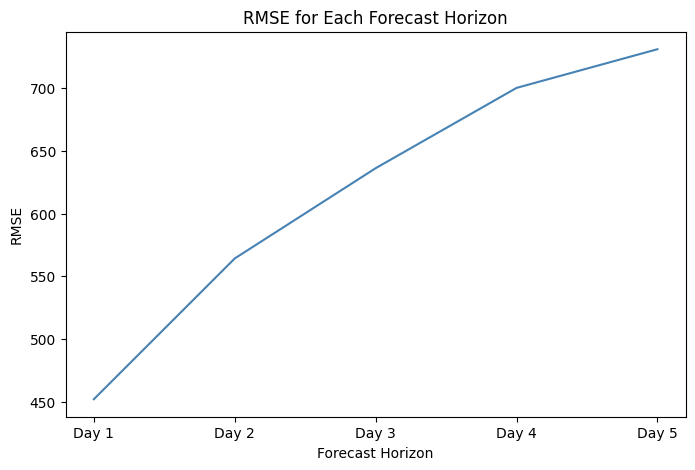

In [156]:
def plot_rmse_for_each_horizon(rmse_dict):
    """
    Plots a bar chart of RMSE for each forecast horizon.
    
    Parameters:
      rmse_dict : Dictionary with keys like 'Day 1', 'Day 2', ... and RMSE values.
    """
    horizons = list(rmse_dict.keys())
    rmse_values = list(rmse_dict.values())
    
    plt.figure(figsize=(8, 5))
    plt.plot(horizons, rmse_values, color='steelblue')
    plt.xlabel("Forecast Horizon")
    plt.ylabel("RMSE")
    plt.title("RMSE for Each Forecast Horizon")
    plt.show()

# Example usage:
rmse_values = compute_rmse_for_each_horizon(post_processed_df, horizon=HORIZON)
plot_rmse_for_each_horizon(rmse_values)

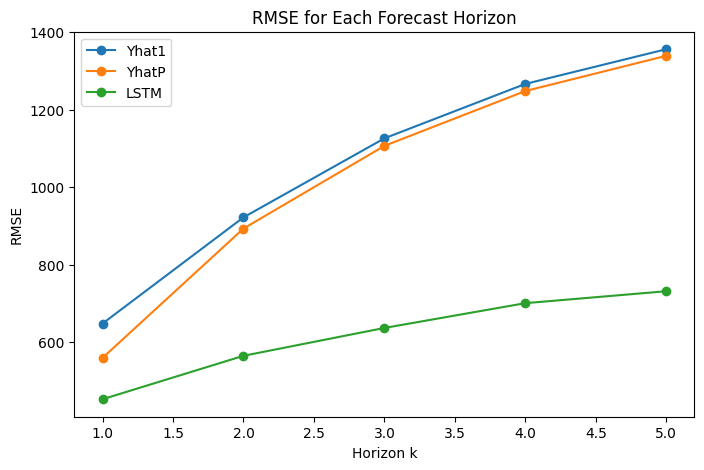

In [157]:
# Hard-coded RMSE values from R
rmse_yhat1 = [647.6976, 922.0222, 1126.1235, 1266.7477, 1356.4172]
rmse_yhatp = [559.0008, 893.0612, 1106.6746, 1248.3544, 1339.4242]

horizons = list(range(1,HORIZON+1))

# Plot each list with a line
plt.figure(figsize=(8, 5))
plt.plot(horizons, rmse_yhat1, marker='o', label='Yhat1')
plt.plot(horizons, rmse_yhatp, marker='o', label='YhatP')
plt.plot(horizons, rmse_values.values(), marker='o', label='LSTM')

plt.xlabel("Horizon k")
plt.ylabel("RMSE")
plt.title("RMSE for Each Forecast Horizon")
plt.legend()
plt.show()

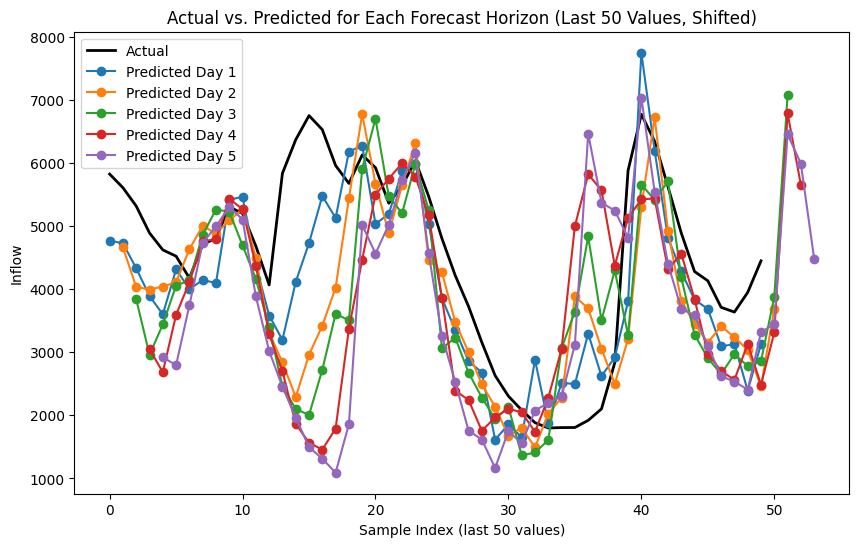

In [158]:
import numpy as np
import matplotlib.pyplot as plt

def plot_multi_horizon_single_actual_shifted(df, horizon=HORIZON, last_n=50):
    """
    Plots one actual line (since all horizons share the same actual values)
    and the predicted values for each forecast horizon on a single figure,
    using only the last 'last_n' samples, but SHIFTING each horizon's line
    so it aligns with the actual day it predicts.

    Assumes the DataFrame has:
      - An actual column named "Day 1 Actual"
      - Predicted columns for each horizon: "Day 1 Pred", "Day 2 Pred", ..., "Day k Pred"

    Parameters:
      df      : DataFrame with at least these columns
      horizon : Number of forecast days (e.g., 5)
      last_n  : How many of the final samples to plot
    """
    plt.figure(figsize=(10, 6))

    # We'll create an x-array for the "last_n" points
    # Day 1 predictions align at x, Day 2 at x+1, Day 3 at x+2, etc.
    x = np.arange(last_n)

    # Plot only the last 'last_n' samples of the actual values
    actual = df["Day 1 Actual"].tail(last_n).values
    plt.plot(x, actual, label="Actual", color="black", linewidth=2)

    # Plot each horizon with a horizontal shift of (i - 1)
    for i in range(1, horizon + 1):
        pred_col = f"Day {i} Pred"
        preds = df[pred_col].tail(last_n).values

        # Shift Day i's predictions by (i-1) steps
        x_shifted = x + (i - 1)
        plt.plot(x_shifted, preds, marker='o', label=f"Predicted Day {i}")

    plt.xlabel(f"Sample Index (last {last_n} values)")
    plt.ylabel("Inflow")
    plt.title(f"Actual vs. Predicted for Each Forecast Horizon (Last {last_n} Values, Shifted)")
    plt.legend()
    plt.show()

# Example usage:
plot_multi_horizon_single_actual_shifted(post_processed_df, horizon=HORIZON, last_n=50)

